In [1]:
import os
import shutil
import zipfile
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from random import sample
import matplotlib.pyplot as plt

In [2]:
import cv2
import skimage
from PIL import Image
from skimage import io, transform, img_as_ubyte, exposure, util

In [3]:
# Library untuk TensorFlow dan Keras
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, InputLayer, SeparableConv2D

  Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
dataset_dir = 'dataset_class_wajah'

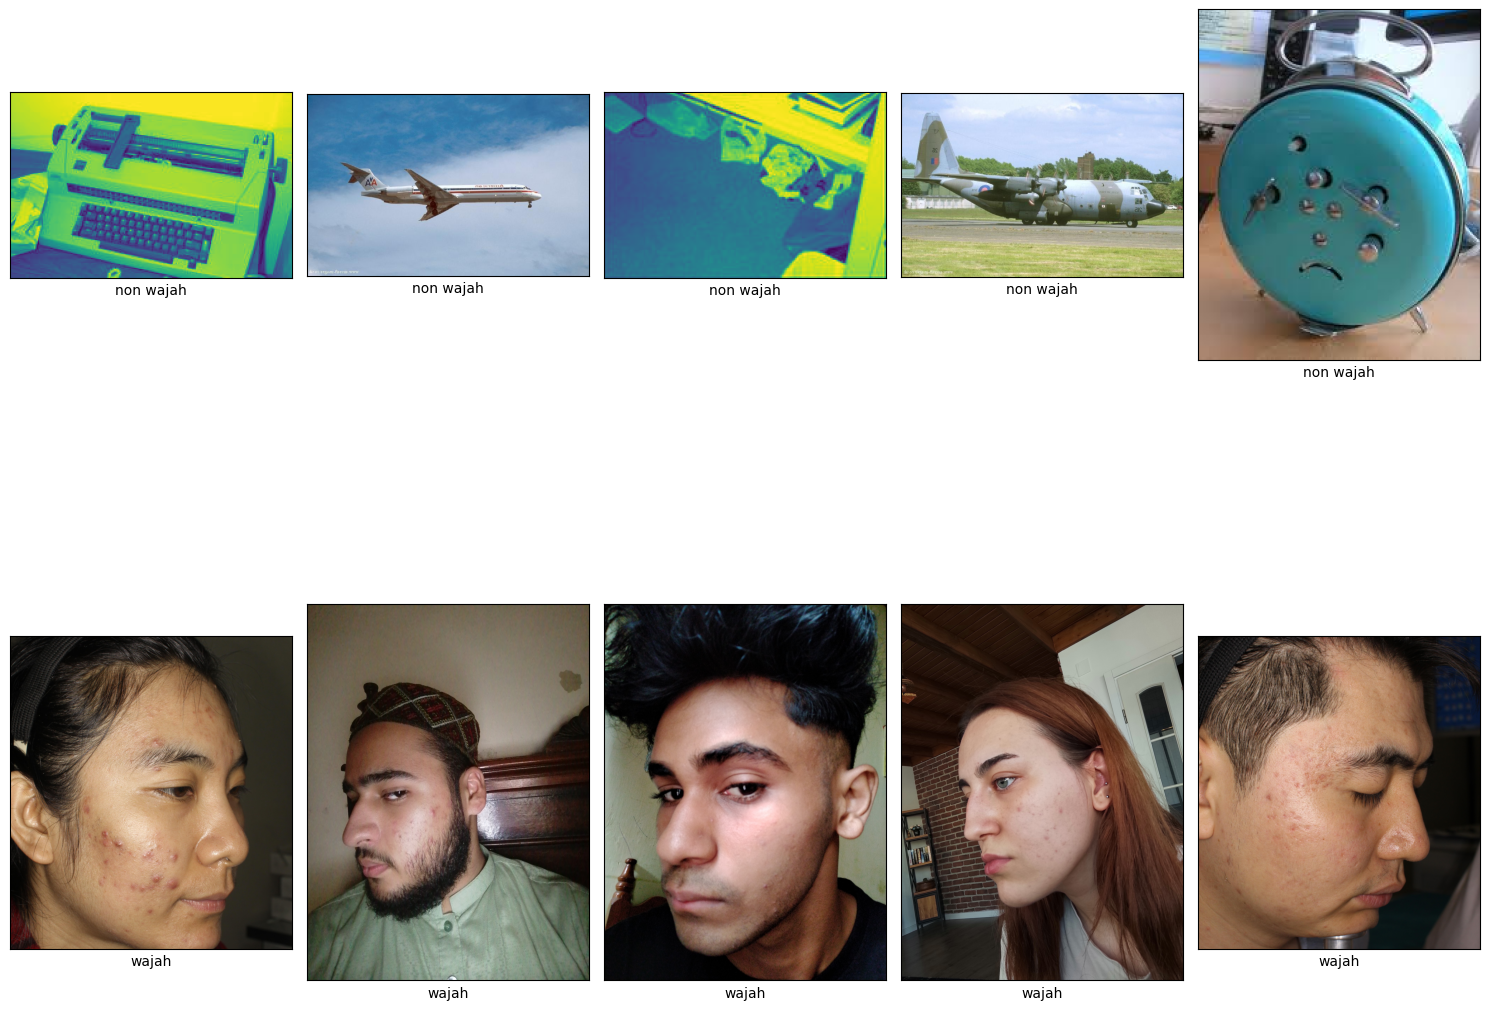

In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
rice_image = {}

# Tentukan path sumber train
path = 'dataset_class_wajah'

# Loop melalui setiap kelas dan simpan daftar nama file gambar dalam dictionary rice_image
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        rice_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data
fig, axs = plt.subplots(len(rice_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(rice_image.keys()):
    images = np.random.choice(rice_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

In [6]:
# Cek Resolusi GAMBAR

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(path)

non wajah: 1983
- (616, 399)
- (321, 213)
- (281, 238)
- (392, 273)
- (206, 244)
- (205, 136)
- (211, 170)
- (342, 272)
- (334, 268)
- (294, 195)
- (201, 251)
- (346, 251)
- (335, 223)
- (276, 183)
- (208, 137)
- (227, 150)
- (225, 217)
- (249, 165)
- (209, 138)
- (427, 351)
- (228, 151)
- (201, 134)
- (150, 61)
- (272, 185)
- (257, 196)
- (160, 105)
- (207, 177)
- (281, 224)
- (384, 255)
- (403, 268)
- (163, 107)
- (182, 120)
- (630, 396)
- (476, 338)
- (284, 177)
- (142, 93)
- (200, 174)
- (222, 174)
- (305, 227)
- (231, 152)
- (140, 132)
- (209, 241)
- (357, 237)
- (394, 286)
- (183, 121)
- (425, 301)
- (252, 202)
- (115, 75)
- (449, 329)
- (196, 167)
- (204, 180)
- (233, 216)
- (137, 90)
- (288, 250)
- (156, 103)
- (131, 168)
- (268, 164)
- (237, 195)
- (301, 198)
- (186, 122)
- (178, 118)
- (368, 297)
- (312, 207)
- (197, 131)
- (331, 220)
- (138, 91)
- (150, 56)
- (308, 255)
- (390, 297)
- (89, 58)
- (361, 239)
- (207, 181)
- (111, 73)
- (497, 374)
- (390, 400)
- (385, 294)
- (21

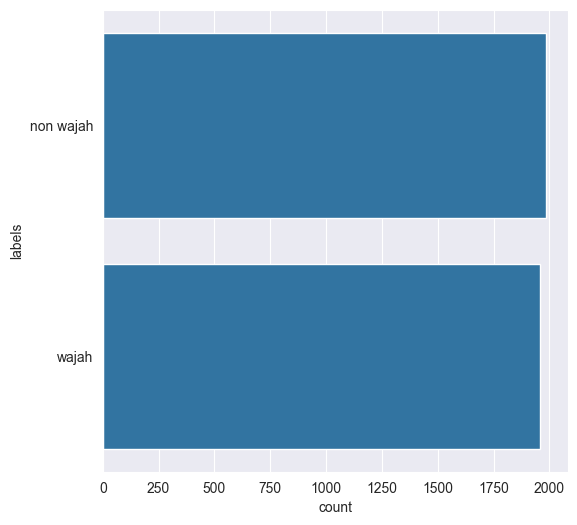

In [8]:
# Definisikan path sumber
Rice_path = "dataset_class_wajah"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for dataset_dir, subdirs, files in os.walk(Rice_path):
    for name in files:
        full_path.append(os.path.join(dataset_dir, name))
        labels.append(os.path.basename(dataset_dir))
        file_name.append(name)

# Buat DataFrame dari data yang dikumpulkan
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

plt.show()

In [9]:
classdir_list = ['non wajah','wajah']

In [10]:
training_percentage = 0.8

In [11]:
training_dataset_dir = 'training'
testing_dataset_dir = 'testing'

os.mkdir(training_dataset_dir)
os.mkdir(testing_dataset_dir)

In [12]:
dataset_dir = r"dataset_class_wajah"

training_dataset_dir = 'training'
testing_dataset_dir = 'testing'

os.makedirs(training_dataset_dir, exist_ok=True)
os.makedirs(testing_dataset_dir, exist_ok=True)

for dirname in classdir_list:
    classpath = os.path.join(dataset_dir, dirname)

    all_files = [f for f in os.listdir(classpath) if os.path.isfile(os.path.join(classpath, f))]
    random.shuffle(all_files)

    training_length = int(training_percentage * len(all_files))

    training_classpath = os.path.join(training_dataset_dir, dirname)
    testing_classpath = os.path.join(testing_dataset_dir, dirname)

    os.makedirs(training_classpath, exist_ok=True)
    os.makedirs(testing_classpath, exist_ok=True)

    for i, filename in enumerate(all_files):
        src_path = os.path.join(classpath, filename)

        if i < training_length:
            dst_path = os.path.join(training_classpath, filename)
        else:
            dst_path = os.path.join(testing_classpath, filename)

        shutil.move(src_path, dst_path)

print("Dataset berhasil dipindahkan ke folder training & testing.")


Dataset berhasil dipindahkan ke folder training & testing.


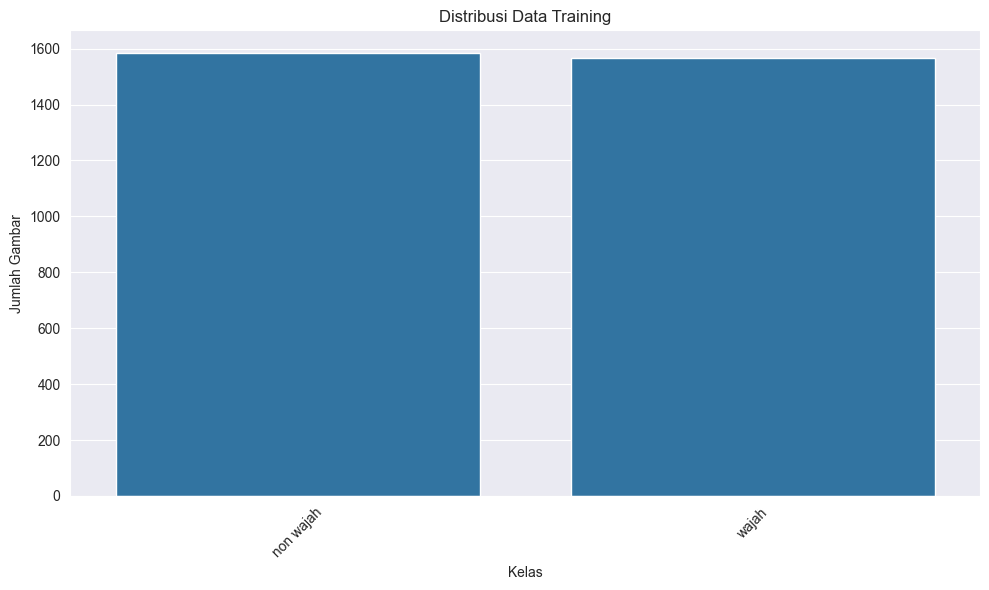

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

training_path = "training"

training_file_name = []
training_labels = []
training_full_path = []

for dataset_dir, subdirs, files in os.walk(training_path):
    for name in files:
        training_full_path.append(os.path.join(dataset_dir, name))
        training_labels.append(os.path.basename(dataset_dir))
        training_file_name.append(name)

distribution_train = pd.DataFrame({
    "path": training_full_path,
    "file_name": training_file_name,
    "labels": training_labels
})

# distribusi data training
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)

plt.title('Distribusi Data Training')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


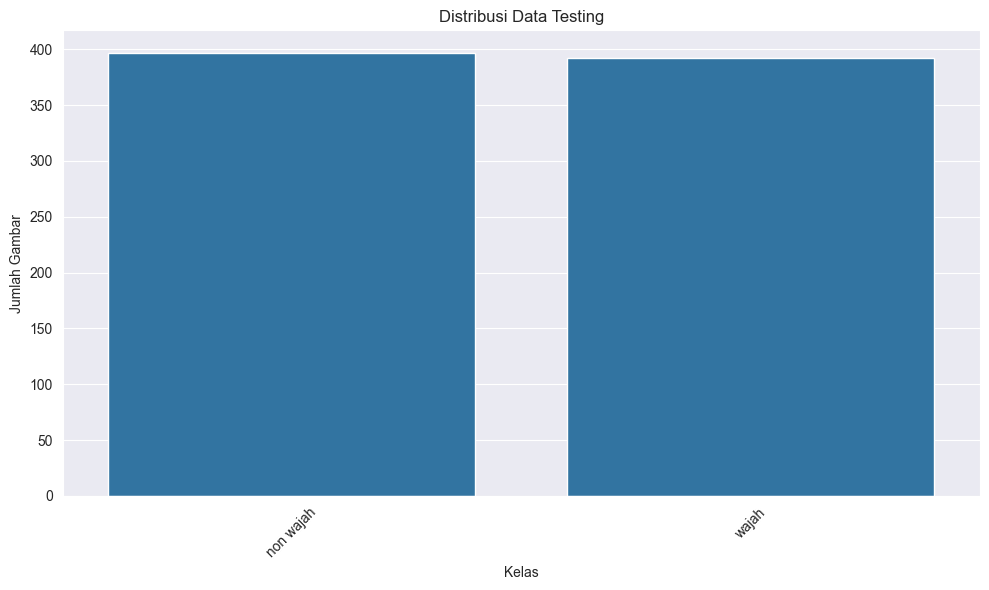

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

testing_path = "testing"

testing_file_name = []
testing_labels = []
testing_full_path = []

for dataset_dir, subdirs, files in os.walk(testing_path):
    for name in files:
        testing_full_path.append(os.path.join(dataset_dir, name))
        testing_labels.append(os.path.basename(dataset_dir))
        testing_file_name.append(name)

distribution_test = pd.DataFrame({
    "path": testing_full_path,
    "file_name": testing_file_name,
    "labels": testing_labels
})

# Plot distribusi data testing
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_test)

plt.title('Distribusi Data Testing')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [15]:
# Data Augmentasi
datagen = ImageDataGenerator(rescale=1./255,
                            validation_split = 0.2,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest',)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(training_path,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(training_path,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(testing_path,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2524 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 789 images belonging to 2 classes.


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [23]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\atheash\AppData\Local\Temp\ipykernel_4844\1534535265.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [24]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [25]:
def create_cnn_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    return model

In [27]:
model = create_cnn_model(input_shape=(150, 150, 3), num_classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\atheash\AppData\Local\Temp\ipykernel_4844\4230000121.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,012,738 (11.49 MB)

 Trainable params: 754,626 (2.88 MB)

 Non-trainable params: 2,258,112 (8.61 MB)

In [33]:
class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=0.95):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if acc is not None and val_acc is not None:
            if acc >= self.target_accuracy and val_acc >= self.target_accuracy:
                print(f"\nTarget akurasi {self.target_accuracy*100}% tercapai pada epoch ke-{epoch+1}, menghentikan pelatihan.")
                self.model.stop_training = True

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
)
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    verbose=1,
    mode='max'
)

In [34]:
checkpoint = ModelCheckpoint('deteksi_wajah.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

In [35]:
from sklearn.utils import class_weight
import numpy as np  # Pastikan NumPy juga sudah di-import

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9944838455476753), 1: np.float64(1.005577689243028)}


In [36]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights_array))

history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint, lr_scheduler, early_stop],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9945 - loss: 0.0271

C:\Users\atheash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.98226, saving model to deteksi_wajah.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9945 - loss: 0.0271 - val_accuracy: 0.9823 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9977 - loss: 0.0061
Epoch 2: val_accuracy improved from 0.98226 to 0.98352, saving model to deteksi_wajah.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9976 - loss: 0.0062 - val_accuracy: 0.9835 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9947 - loss: 0.0209
Epoch 3: val_accuracy improved from 0.98352 to 0.99366, saving model to deteksi_wajah.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9947 - loss: 0.0208 - val_accuracy: 0.9937 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9967 - loss: 0.0116
Epoch 4: val_accuracy did not improve from 0.99366
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9967 - loss: 0.0116 - val_accuracy: 0.9911 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0098
Epoch 5: val_accuracy did not improve from 0.99366
79/79 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9911 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9950 - loss: 0.0143
Epoch 6: val_accuracy did not improve from 0.99366

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
79/79 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9950 - loss: 0.0143 - val_accuracy: 0.9873 - va

In [37]:
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

# a. SavedModel
saved_model_path = 'saved_model'
model.export(saved_model_path)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_path}")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1516477829136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477829904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477830480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477830096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477828176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477831824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477832208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477832592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477832400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477827792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477833744: TensorSpec(shape=(),

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = 'tflite/model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Buat file label.txt untuk TF-Lite
class_names = list(train_generator.class_indices.keys())
label_path = 'tflite/label.txt'
with open(label_path, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")
print(f"Model dan label berhasil disimpan dalam format TF-Lite di: tflite")

INFO:tensorflow:Assets written to: C:\Users\atheash\AppData\Local\Temp\tmpltmqp2ar\assets


INFO:tensorflow:Assets written to: C:\Users\atheash\AppData\Local\Temp\tmpltmqp2ar\assets


Saved artifact at 'C:\Users\atheash\AppData\Local\Temp\tmpltmqp2ar'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1516477829136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477829904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477830480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477830096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477828176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477831824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477832208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477832592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477832400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1516477827792: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [43]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # simpan struktur folder relatif
                arcname = os.path.relpath(file_path, start=folder_path)
                zipf.write(file_path, arcname)

    print(f"Folder '{folder_path}' berhasil dikompresi ke: {zip_path}")

# Ganti dengan path yang sesuai
zip_folder('saved_model', 'saved_model.zip')


Folder 'saved_model' berhasil dikompresi ke: saved_model.zip
